In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.python.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Preparing Dataset

In [ ]:
root_path = 'gdrive/My Drive/chest_xray/'

In [ ]:
import pathlib
#data_directory = "/train"
data_directory = pathlib.Path(root_path)

In [ ]:
train_path = 'gdrive/My Drive/chest_xray/train/'
train_directory = pathlib.Path(train_path)
train_normal_count = len(list(train_directory.glob('NORMAL/*'))) #calculate number of NORMAL images
train_pneum_count = len(list(train_directory.glob('PNEUMONIA/*'))) #calculate number of PNEUMONIA images

In [ ]:
img_height,img_width=180,180
batch_size=8
#create train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_directory,
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [ ]:
val_path = 'gdrive/My Drive/chest_xray/val/'
val_directory = pathlib.Path(val_path)

In [ ]:
#create val data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_directory,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16 files belonging to 2 classes.


# Training The Model


In [ ]:
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=2,
                   weights='imagenet') #transfer learning model

In [ ]:
pretrained_model.trainable = False #setting layers as untrainable/freezing
inputs = tf.keras.Input(shape=(180,180,3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = pretrained_model(x, training = False) #set layers in inference mode
#x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x) #one output neuron for binary classification
model = tf.keras.Model(inputs, outputs)

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049

In [ ]:
#calculate class weights
#counteract the effect of class imbalance
weight_for_normal = 1.0 / train_normal_count
weight_for_pneum = 1.0 / train_pneum_count
class_weight = {0: weight_for_normal,
                1: weight_for_pneum}

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  class_weight=class_weight,
  callbacks = [early_callback]
)

Epoch 1/50
652/652 [==============================] - 36s 55ms/step - loss: 4.3442e-05 - accuracy: 0.9565 - val_loss: 0.2842 - val_accuracy: 0.8125
Epoch 2/50
652/652 [==============================] - 38s 57ms/step - loss: 3.9993e-05 - accuracy: 0.9590 - val_loss: 0.2866 - val_accuracy: 0.8125
Epoch 3/50
652/652 [==============================] - 37s 56ms/step - loss: 3.8556e-05 - accuracy: 0.9584 - val_loss: 0.2900 - val_accuracy: 0.8125
Epoch 4/50
652/652 [==============================] - 38s 58ms/step - loss: 3.6650e-05 - accuracy: 0.9607 - val_loss: 0.2963 - val_accuracy: 0.8125
Epoch 5/50
652/652 [==============================] - 37s 56ms/step - loss: 3.6063e-05 - accuracy: 0.9622 - val_loss: 0.2955 - val_accuracy: 0.8125
Epoch 6/50
652/652 [==============================] - 37s 56ms/step - loss: 3.4011e-05 - accuracy: 0.9659 - val_loss: 0.2163 - val_accuracy: 0.8750
Epoch 7/50
652/652 [==============================] - 37s 56ms/step - loss: 3.4445e-05 - accuracy: 0.9647 - val_

# Evaluating The Model

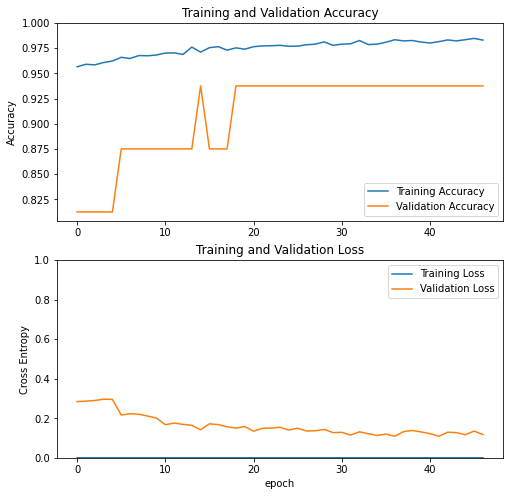

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine-tuning The Model

In [ ]:
# Save the weights
model.save_weights('gdrive/My Drive/checkpoints/original_weights')

In [ ]:
print("Number of layers in the base model: ", len(pretrained_model.layers))

Number of layers in the base model:  176


In [ ]:
fine_tune_from_arr = [120] #insert other values to test
for fine_tune in fine_tune_from_arr:
  #create model
  pretrained_model.trainable = True
  inputs = tf.keras.Input(shape=(180,180,3))
  x = tf.keras.applications.resnet50.preprocess_input(inputs)
  x = pretrained_model(x, training = False)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1, activation = "sigmoid")(x)
  model = tf.keras.Model(inputs, outputs)
  model.load_weights('gdrive/My Drive/checkpoints/original_weights') #loading original weights
  for layer in pretrained_model.layers[:fine_tune]:
    layer.trainable = False #freeze layer up till specified number
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr/10), #training at a lower learning rate
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
  ft_epochs = 8
  total_epoch = epochs + ft_epochs
  history_fine = model.fit(train_ds,
                          epochs=total_epoch,
                          initial_epoch=history.epoch[-1],
                          validation_data=val_ds)
  print("min loss for fine tune at " + str(fine_tune) +": " + str(min(history_fine.history['val_loss']))) #compare min loss for each value in fine_tune array

Epoch 47/58
652/652 [==============================] - 46s 64ms/step - loss: 0.2439 - accuracy: 0.9319 - val_loss: 0.5318 - val_accuracy: 0.6875
Epoch 48/58
652/652 [==============================] - 43s 66ms/step - loss: 0.0531 - accuracy: 0.9827 - val_loss: 0.1626 - val_accuracy: 0.9375
Epoch 49/58
652/652 [==============================] - 41s 62ms/step - loss: 0.0368 - accuracy: 0.9883 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 50/58
652/652 [==============================] - 41s 63ms/step - loss: 0.0168 - accuracy: 0.9937 - val_loss: 3.0066e-04 - val_accuracy: 1.0000
Epoch 51/58
652/652 [==============================] - 41s 62ms/step - loss: 0.0223 - accuracy: 0.9939 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 52/58
652/652 [==============================] - 41s 62ms/step - loss: 0.0127 - accuracy: 0.9944 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 53/58
652/652 [==============================] - 41s 62ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.0018 - va

# Making Predictions with Optimal Model

In [ ]:
#load test path
test_path = 'gdrive/My Drive/chest_xray/test/'
test_directory = pathlib.Path(test_path)
test_normal_count = len(list(test_directory.glob('NORMAL/*')))
test_pneum_count = len(list(test_directory.glob('PNEUMONIA/*')))

In [ ]:
#create test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_directory,
  labels='inferred',
  seed=123,
  image_size=(img_height, img_width),
  batch_size= 1)

Found 624 files belonging to 2 classes.


In [ ]:
#making predictions while collecting the actual labels since the dataset has been shuffled
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, model.predict(x).flatten()])
  labels = np.concatenate([labels, y])

1/1 [==============================] - 0s 18ms/step


In [ ]:
#convert the predictions to binary values for confusion matrix
binary_predictions = [int(round(i)) for i in predictions]

# Analysing Performance

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.82       234
         1.0       0.85      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.86       624
weighted avg       0.89      0.88      0.87       624



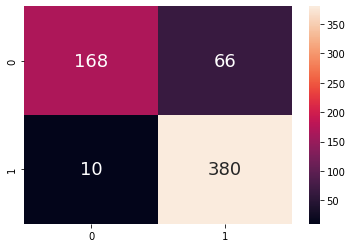

In [ ]:
#confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
print(classification_report(labels, binary_predictions))

# Plot the two-way Confusion Matrix
sns.heatmap(confusion_matrix(labels, binary_predictions), 
           annot = True, fmt=".0f", annot_kws={"size": 18})